# CE811 Multi-Armed Bandit Simulator Notebook
# (Working with UCB1 and Seaborn)
November 2021.  Dr Michael Fairbank. 
University of Essex.

## Running a Multi-Armed Bandit simulation

- Objectives: Learn more about expectation, UCB1, and Epsilon-Greedy Policy.
- Co-objective: Learn about plotting graphs for experimental results in Pandas + Seaborn.  This might help you in Assignment 2.

Instructions: Go through each code block, study and make sure you understand each of them, and fill in **the three** missing "TODO" parts.

## Before you start
- Check you have the python packages numpy, seaborn and pandas installed.
- e.g. install them with "pip3 install numpy, matplotlib, seaborn, pandas"

## Program each bandit

- We're not meant to know what goes on inside each bandit, but we have to program them somehow.

- Every bandit has 3 internal variables - [bandit_prob_success, bandit_mean, bandit_sd]

- Study this code block, but do not alter it

edited it to raise ValueError because IllegalArgumentException isn't a thing in Python


In [41]:
import math
import random

import numpy as np

bandit_behaviours=[[0.5,1,.4],[0.7,.2,0.05],[0.2,4,.4]] # Secret settings for each machine.
num_bandits=len(bandit_behaviours) # 3 machines in this example

def run_bandit(bandit_number):
    if bandit_number<0 or bandit_number>=len(bandit_behaviours):
        raise ValueError('Invalid Bandit Number')
    [bandit_prob_payout, bandit_mean, bandit_sd]=bandit_behaviours[bandit_number]
    if np.random.rand()<bandit_prob_payout:
        # This bandit will pay out something on this attempt.
        # Generate a random number, from the normal distribution,
        # with required mean and standard-deviation for this bandit.
        payout=np.random.normal(loc=bandit_mean, scale=bandit_sd)
    else:
        # this bandit did not give out anything on this attempt
        payout=0.0
    return payout
    

## Calculate expectations of payouts

- Edit the code below to calculate the expectation of the payout for each machine.  

- Should get an answer 0.5,0.14,0.8, meaning that the 3rd machine is the best one to play long term, and also meaning that the best long-term average payoff we can ever hope for is 0.8.

- Again, this is not something we are meant to know about the bandit machines.

In [42]:
def calc_expected_payout(bandit_prob_payout, bandit_mean, bandit_sd):

    #upper_bound = bandit_mean + bandit_sd
    #lower_bound = bandit_mean - bandit_sd

    #overall = bandit_prob_payout * ((upper_bound + lower_bound)/2)

    overall = bandit_prob_payout * bandit_mean

    return overall # TODO fix this

for bandit_number in range(num_bandits):
    [bandit_prob_payout, bandit_mean, bandit_sd]=bandit_behaviours[bandit_number]
    expected_payout=calc_expected_payout(bandit_prob_payout, bandit_mean, bandit_sd)
    print("Bandit",bandit_number,"Expected Payout",expected_payout)

Bandit 0 Expected Payout 0.5
Bandit 1 Expected Payout 0.13999999999999999
Bandit 2 Expected Payout 0.8


## Program the UCB1 and Epsilon-Greedy strategies

- Update the code below to include the UCB1 strategy with argument c, and epsilon-greedy policy with argument epsilon.
- Note that the passed in arguments num_plays_per_bandit, total_payout_per_bandit are both numpy arrays (of length=num_bandits), so it is possible to do fast computation on them using np.sqrt, np.log, np.argmax.  You will need to explicitly compute the mean_payout of each machine so far, e.g. by using a fast numpy vector-vector divide.
- Reminder: the UCB1 formula is $UCB1=V_i+c \sqrt{\frac{log_e(N)}{N_i}}$, where $V_i$ is the average payout so far of machine $i$, $N_i$ is the number of times machine number $i$ has been played so far, $N$ is the total number of times all machines have been played so far (So $N=\sum_i N_i$), and $c$ is an exploration constant.

In [43]:


def run_strategy_ucb1(num_plays_per_bandit, total_payout_per_bandit,c):
    num_bandits=len(num_plays_per_bandit)
    assert len(total_payout_per_bandit)==len(num_plays_per_bandit)
    # on entry, num_plays_per_bandit and total_payout_per_bandit are numpy arrays of shape [num_bandits].
    # TODO insert code here.  It needs to run the UCB1 algorithm, with constant c, and return the integer
    # number of the bandit to play next.   It does NOT need to update the arrays num_plays_per_bandit etc.

    #mean_per_bandit: np.ndarray = np.divide(total_payout_per_bandit, num_plays_per_bandit)

    #logn_per_bandit: np.ndarray = np.multiply(np.sqrt(np.divide(np.log(np.sum(num_plays_per_bandit)), num_plays_per_bandit)), c)

    #return np.add(mean_per_bandit, logn_per_bandit).argmax(axis=0)
    return np.add(
        np.divide(total_payout_per_bandit, num_plays_per_bandit),
        np.multiply(np.sqrt(np.divide(np.log(np.sum(num_plays_per_bandit)), num_plays_per_bandit)), c)
    ).argmax(axis=0)

def run_strategy_random(num_plays_per_bandit, total_payout_per_bandit):
    num_bandits=len(num_plays_per_bandit)
    assert len(total_payout_per_bandit)==len(num_plays_per_bandit)
    # on entry, num_plays_per_bandit and total_payout_per_bandit are numpy arrays of shape [num_bandits].
    return np.random.randint(num_bandits)

def run_strategy_epsilon_greedy(num_plays_per_bandit, total_payout_per_bandit, epsilon):
    num_bandits=len(num_plays_per_bandit)
    assert len(total_payout_per_bandit)==len(num_plays_per_bandit)
    # on entry, num_plays_per_bandit and total_payout_per_bandit are numpy arrays of shape [num_bandits].
    # TODO insert code here.  It needs to run the epsilon-greedy algorithm, with constant epsilon, 
    # and return an integer number of the bandit to play next.   
    # It does NOT need to update the arrays num_plays_per_bandit etc.
    if np.random.rand() < epsilon:
        return np.random.randint(num_bandits)
    else:
        return total_payout_per_bandit.argmax(axis=0)

## Run main experiment loop

In [44]:
result_data=[]
trial_count: int = 100
for trial in range(trial_count): # we are running each set of parameters a large number of times to get statistically signficant results.
    for [alg,alg_argument] in [["UCB1",0],["UCB1",1],["UCB1",2],["RANDOM",0],["EGREEDY",0.1],["EGREEDY",0.3], ["UCB1",math.sqrt(2)]]:
        algorithm_name=alg+"("+str(alg_argument)+")"
        
        # Run every bandit once before we start properly:
        total_payout_per_bandit=np.array([run_bandit(i) for i in range(num_bandits)])
        num_plays_per_bandit=np.array([1.0]*3)
        
        # Now run chosen algorithm 10000 times:
        for iteration in range(10000):
            if alg=="UCB1":
                bandit_choice=run_strategy_ucb1(num_plays_per_bandit, total_payout_per_bandit,alg_argument)
            elif alg=="EGREEDY":
                bandit_choice=run_strategy_epsilon_greedy(num_plays_per_bandit, total_payout_per_bandit,alg_argument)
            elif alg=="RANDOM":
                bandit_choice=run_strategy_random(num_plays_per_bandit, total_payout_per_bandit)
            payout=run_bandit(bandit_choice)
            # Update the 2 statistics arrays:
            total_payout_per_bandit[bandit_choice]+=payout
            num_plays_per_bandit[bandit_choice]+=1
            
            # Record the data into a results list, for plotting purposes.
            # Only record every 100th row for now, to save space + improve speed.
            if iteration%100==0: 
                result_data.append([algorithm_name, trial, iteration, total_payout_per_bandit.sum()/num_plays_per_bandit.sum(),bandit_choice])
    print("Trial {:3d}/{:3d} done".format(trial+1, trial_count))

Trial   1/100 done
Trial   2/100 done
Trial   3/100 done
Trial   4/100 done
Trial   5/100 done
Trial   6/100 done
Trial   7/100 done
Trial   8/100 done
Trial   9/100 done
Trial  10/100 done
Trial  11/100 done
Trial  12/100 done
Trial  13/100 done
Trial  14/100 done
Trial  15/100 done
Trial  16/100 done
Trial  17/100 done
Trial  18/100 done
Trial  19/100 done
Trial  20/100 done
Trial  21/100 done
Trial  22/100 done
Trial  23/100 done
Trial  24/100 done
Trial  25/100 done
Trial  26/100 done
Trial  27/100 done
Trial  28/100 done
Trial  29/100 done
Trial  30/100 done
Trial  31/100 done
Trial  32/100 done
Trial  33/100 done
Trial  34/100 done
Trial  35/100 done
Trial  36/100 done
Trial  37/100 done
Trial  38/100 done
Trial  39/100 done
Trial  40/100 done
Trial  41/100 done
Trial  42/100 done
Trial  43/100 done
Trial  44/100 done
Trial  45/100 done
Trial  46/100 done
Trial  47/100 done
Trial  48/100 done
Trial  49/100 done
Trial  50/100 done
Trial  51/100 done
Trial  52/100 done
Trial  53/10

## Convert code to pandas dataframe

- Pandas is a python library that helps you manipulate large blocks of data in a convenient way, https://pandas.pydata.org/
- Pandas is a major tool in the machine-learning python libraries, e.g. see https://www.youtube.com/watch?v=dPwLlJkSHLo&t=652s to learn more
- The code block below puts our experiment data into a pandas "dataframe"
- It also saves the data into a csv file. So we can do post-processing and graphing in a different program if necessary.
- Make sure you open the CSV file to have a look at the contents.

In [45]:
import pandas as pd
df = pd.DataFrame(columns=['Algorithm_Name','trial','iter','av_payout','Choice'],data=result_data)
print(df.head()) # print the first 5 rows to check it looks okay
df.to_csv("experimental_raw_data.csv") # save data to a csv file 

  Algorithm_Name  trial  iter  av_payout  Choice
0        UCB1(0)      0     0   0.538575       0
1        UCB1(0)      0   100   0.424141       0
2        UCB1(0)      0   200   0.442362       0
3        UCB1(0)      0   300   0.477148       0
4        UCB1(0)      0   400   0.492328       0


### Once data is in pandas, you can manipulate it with sql-like queries

In [46]:
# create a new dataframe, df2, which is a subset of the rows in the original dataframe
df2=df.query("trial==3 and Algorithm_Name=='UCB1(1)'")
# print out the first 5 rows of the new dataframe...
df2.head()

,Algorithm_Name,trial,iter,av_payout,Choice
2200,UCB1(1),3,0,1.706888,2
2201,UCB1(1),3,100,0.821319,2
2202,UCB1(1),3,200,0.783429,2
2203,UCB1(1),3,300,0.690889,2
2204,UCB1(1),3,400,0.624381,2


### We could use matplotlib + pandas to plot individual curves...

- Reminder: We previously saw how matplotlib can be used to plot graphs in labs 2+3.
- Really this next block should be a different program in the pipeline, hence we'd want to load our experimental data from the csv file - uncomment out the first line to achieve this
- Here we use matplotlib to plot results from several trials, as follows:

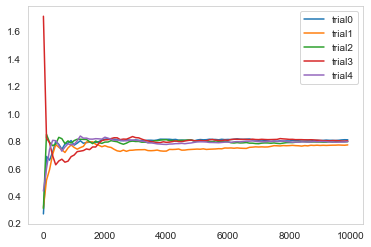

In [47]:
# df=pd.read_csv("experimental_raw_data.csv") 
import matplotlib.pyplot as plt
num_trials=df.trial.max() # This tells us what the maximum value of the "trial" column is in the dataframe.
for t in range(5):
    df2=df.query("trial=="+str(t)+" and Algorithm_Name=='UCB1(1)'")
    plt.plot(df2["iter"],df2["av_payout"], label="trial"+str(t))
plt.legend()
plt.grid()


## Plot summary graphs with seaborn

In the above graphs, we don't care so much about the individual curves from each trial, but more so about their aggregate properties.  We want to see the mean of the trials for each experimental setup, and how much spread there is.  

- For this, we will use another python library, Seaborn, https://seaborn.pydata.org/
- Seaborn is very good for plotting the contents of a pandas dataframe, showing one variable against another, and splitting the data into several different curves based on a 3rd variable - each curve having a different "hue".  This is fantastic for seeing the effect that changing the 3rd variable has on the y-variable.
- Seaborn also aggregates all of the trials we did for any combination of parameters, and shows the resulting average of all of those trials - so it is very good for only showing statistically significant results.  Better than plotting the curves individually like was done in the above block.
- Also if you remove the ci=None, then it will plot "confidence intervals" too onto your graph, which is the standard error showing uncertainty in the average curves plotted.  However the confidence-intervals calculation is very slow - I suggest, for speed, that you only include every 100th row of data if you want confidence intervals plotting.


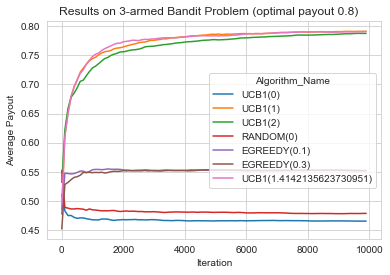

In [48]:
# df=pd.read_csv("experimental_raw_data.csv") 
import seaborn as sns
import matplotlib as mpl
palette=sns.color_palette()
sns.set_style("whitegrid")
snsplt = sns.lineplot(data=df, x="iter",  y="av_payout", hue="Algorithm_Name", ci=None)
snsplt.set(xlabel='Iteration', ylabel='Average Payout')
fig = snsplt.get_figure()
fig.suptitle("Results on 3-armed Bandit Problem (optimal payout 0.8)", fontsize=12,y=0.93)
fig.savefig("result_graph.pdf")

Look at the graph above and work out which algorithm gets closest to optimal payout (0.8) the fastest.

### Final Tidy up of Graphs and Boost the Sample sizes

- Increase the number of trials in the main experimental loop from 20 to 100, to achieve something that has greater statistical signficance.

- Note that while developing, for speed, we want the number of trials to be low.  But at the end of development, always increase it, to make your results more trust-worthy.